## Logistic Regression on Amazon Fine Food Reviews

### 1 Importing all necessary libraries

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3 
import nltk
import string
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score
import re
from sklearn import preprocessing
import warnings
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from prettytable import PrettyTable
warnings.filterwarnings("ignore")


##### 2 Loading the cleaned data directly which is preprocessed and stored in final.sqlite

In [2]:
import sqlite3
con = sqlite3.connect("final.sqlite")
cleaned_data = pd.read_sql_query("select * from Reviews", con)
cleaned_data.shape
#cleaned_data.head()

(364171, 12)

In [3]:
#Sampling 100k points

final_data = cleaned_data.sample(n=100000)
final_data.shape
final_data['Score'].value_counts()

positive    84337
negative    15663
Name: Score, dtype: int64

In [4]:
# sorting the data based on time

final_data['Time'] = pd.to_datetime(final_data['Time']).sort_values()
#final_data.head()

#### Function to find optimal C using GridSearchCV

In [16]:
def find_optimal_C_grid(X_train,Y_train):
   
    tuned_parameters = {'C': [10**-4, 10**-2, 10**0, 10**2, 10**4],'penalty':['l1','l2']}
    tscv = TimeSeriesSplit(n_splits=5)
    model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1_micro',cv=tscv)
    model.fit(X_train, Y_train)
  
    print(model.best_params_)
    model_mean_scores = [result.mean_validation_score for result in model.grid_scores_]
    MSE = [1 - x for x in model_mean_scores]
    MSE_l1 = [MSE[x] for x in range(0,5)]
    MSE_l2 = [MSE[x] for x in range(5,10)]
    plt.plot([10**-4, 10**-2, 10**0, 10**2, 10**4], MSE_l1,'r-',label = 'L1')
    plt.plot([10**-4, 10**-2, 10**0, 10**2, 10**4], MSE_l2,'b-',label ='L2')
    plt.legend()
    plt.xlabel('Optimal C')
    plt.ylabel('CV Error')
    plt.title('CV Error Vs C')
    
    #return optimal_lambda

#### Function to find optimal C using RandomSearchCV

In [28]:
def find_optimal_C_random(X_train,Y_train):
   
    tuned_parameters = {'C': [10**-4, 10**-2, 10**0, 10**2, 10**4],'penalty':['l1','l2']}
    tscv = TimeSeriesSplit(n_splits=5)
    model1 = RandomizedSearchCV(LogisticRegression(),tuned_parameters,scoring = 'f1_micro', cv=tscv)
    model1.fit(X_train, Y_train)
  
    print(model1.best_params_)
    
    model1_mean_scores = [result.mean_validation_score for result in model1.grid_scores_]
    MSE = [1 - x for x in model1_mean_scores]
    MSE_l1 = [MSE[x] for x in range(0,5)]
    MSE_l2 = [MSE[x] for x in range(5,10)]
    plt.plot([10**-4, 10**-2, 10**0, 10**2, 10**4], MSE_l1,'r-',label = 'L1')
    plt.plot([10**-4, 10**-2, 10**0, 10**2, 10**4], MSE_l2,'b-',label ='L2')
    plt.legend()
    plt.xlabel('Optimal C')
    plt.ylabel('CV Error')
    plt.title('CV Error Vs C')
    
    #return optimal_lambda

#### Function to find the top 25 features

In [7]:
def find_imp_features(vectorizer):
    feature_names =vectorizer.get_feature_names()
    coef_fnames = sorted(zip(clf.coef_[0], feature_names))
    top_class_negative = coef_fnames[:25]
    print("Top 25 negative\n\n",top_class_negative)
    print('-------------------------------------------')
    top_class_positive = coef_fnames[-26:]
    print("Top 25 positive\n\n",top_class_positive)

### 2 BOW

In [8]:
# Splitting the data into train and test
X = final_data['CleanedText']
Y = final_data['Score']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
print(X_train.shape,X_test.shape)
#print(X_train)
type(X_train)

(70000,) (30000,)


pandas.core.series.Series

In [9]:
# converting text to vector using Bag of Words
unigram_bow = CountVectorizer()

#Train vectorizer
X_train = unigram_bow.fit_transform(X_train)
scaler = preprocessing.StandardScaler(with_mean=False).fit(X_train)
X_train = scaler.transform(X_train)  

X_test = unigram_bow.transform(X_test)
X_test = scaler.transform(X_test) 

print(X_train.shape,X_test.shape)


(70000, 32187) (30000, 32187)


#### GridSearch CV

{'C': 0.01, 'penalty': 'l1'}


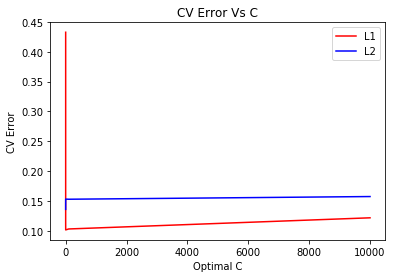

In [17]:
# finding optimal alpha
optimalc_bow_grid = find_optimal_C_grid(X_train, Y_train)

In [21]:
# Learning the model with optimal alpha
clf = LogisticRegression(C= 0.01, penalty = 'l1')
# fitting the model
clf.fit(X_train,Y_train)

#Predicting the output
pred = clf.predict(X_test)

train_acc_bow = clf.score(X_train, Y_train)*100
print("Train accuracy", train_acc_bow)

test_acc_bow = accuracy_score(Y_test, pred) * 100
print("\nTest accuracy", test_acc_bow)

Train accuracy 93.88714285714286

Test accuracy 91.14999999999999


             precision    recall  f1-score   support

   negative       0.82      0.55      0.66      4671
   positive       0.92      0.98      0.95     25329

avg / total       0.91      0.91      0.90     30000



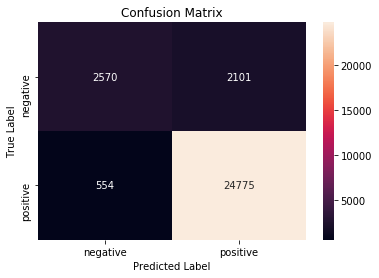

In [22]:
# classification report
print(classification_report(Y_test, pred))

# Confusion matrix
import seaborn as sns
class_label = ["negative", "positive"]
cm = confusion_matrix(Y_test, pred)
cm_array = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(cm_array, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### RandomisedSearch CV

{'penalty': 'l1', 'C': 0.01}


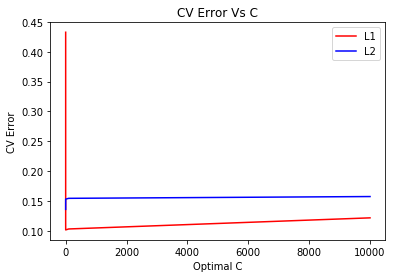

In [29]:
# finding optimal alpha
optimalc_bow_random = find_optimal_C_random(X_train, Y_train)

In [30]:
# Learning the model with optimal alpha
clf = LogisticRegression(C= 0.01, penalty = 'l1')
# fitting the model
clf.fit(X_train,Y_train)

#Predicting the output
pred = clf.predict(X_test)

train_acc_bow_random = clf.score(X_train, Y_train)*100
print("Train accuracy", train_acc_bow_random)

test_acc_bow_random = accuracy_score(Y_test, pred) * 100
print("\nTest accuracy", test_acc_bow_random)

Train accuracy 93.88714285714286

Test accuracy 91.13666666666667


             precision    recall  f1-score   support

   negative       0.82      0.55      0.66      4671
   positive       0.92      0.98      0.95     25329

avg / total       0.91      0.91      0.90     30000



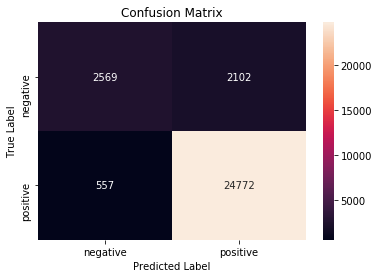

In [31]:
# classification report
print(classification_report(Y_test, pred))
# Confusion matrix
import seaborn as sns
class_label = ["negative", "positive"]
cm = confusion_matrix(Y_test, pred)
cm_array = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(cm_array, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

##### Relation between sparsity and lambda

In [26]:
clf = LogisticRegression(C=10000, penalty='l1')
clf.fit(X_train, Y_train)
w = clf.coef_
print(np.count_nonzero(w))

22609


In [27]:
clf = LogisticRegression(C=1000, penalty='l1')
clf.fit(X_train, Y_train)
w = clf.coef_
print(np.count_nonzero(w))

19659


In [28]:
clf = LogisticRegression(C=100, penalty='l1')
clf.fit(X_train, Y_train)
w = clf.coef_
print(np.count_nonzero(w))

17856


In [29]:
clf = LogisticRegression(C=10, penalty='l1')
clf.fit(X_train, Y_train)
w = clf.coef_
print(np.count_nonzero(w))

15326


In [30]:
clf = LogisticRegression(C=0.1, penalty='l1')
clf.fit(X_train, Y_train)
w = clf.coef_
print(np.count_nonzero(w))

11045


In [31]:
clf = LogisticRegression(C=0.001, penalty='l1')
clf.fit(X_train, Y_train)
w = clf.coef_
print(np.count_nonzero(w))

82


We can observe that as lambda increases/C decreases sparsity increases

#### Multicollinearity

In [32]:
clf = LogisticRegression(C=0.01, penalty='l2')
clf.fit(X_train, Y_train)
coef = clf.coef_[0]
print("Weights before adding noise\n")
print(coef[:30])
print(len(coef))

Weights before adding noise

[-5.88980389e-09  2.56795089e-03  1.66439876e-05 -3.87059649e-09
 -4.14008488e-09  9.78117277e-09  7.08547457e-04 -1.96206575e-08
 -1.87815762e-02  1.00584262e-05 -1.18516763e-08  2.07870203e-06
  1.63697625e-03  1.06293494e-02  1.86641117e-02  7.36362033e-06
 -3.65340652e-08  6.87746343e-05  3.85218206e-03  8.16988690e-03
  3.38997709e-03  9.25795148e-04  7.76810936e-02 -1.13188021e-02
 -5.12184740e-03  1.54192881e-06  5.95631722e-03  6.17641604e-03
 -1.54043548e-03  4.09511548e-04]
32376


In [33]:
X_train1 = X_train
noise = np.random.normal(0,0.01) 
X_train1.data = X_train1.data + noise
print(X_train1.shape)

(70000, 32376)


In [34]:
clf = LogisticRegression(C=0.01, penalty='l2')
clf.fit(X_train1, Y_train)
coef_withNoise = clf.coef_[0]
print("Weights after adding noise\n")
print(coef_withNoise[:30])
print(len(coef_withNoise))

Weights after adding noise

[-8.87801446e-11  2.56948768e-03  1.66278755e-05 -1.25828961e-11
 -1.61857587e-12  3.29441561e-08  7.06449063e-04 -5.52448758e-11
 -1.87863759e-02  1.00324503e-05 -1.00060634e-10  2.60051219e-06
  1.63788052e-03  1.06289074e-02  1.86486587e-02  7.34242992e-06
 -1.19158273e-09  6.90928846e-05  3.85014387e-03  8.17234690e-03
  3.39236761e-03  9.22811484e-04  7.76734607e-02 -1.13138590e-02
 -5.12021374e-03  1.55352705e-06  5.95360016e-03  6.17430460e-03
 -1.53963561e-03  4.08716144e-04]
32376


In [35]:
Weights_diff = (abs(coef-coef_withNoise)/coef) * 100
print(Weights_diff[:30])
type(Weights_diff)

[-9.84926468e+01  5.98448112e-02  9.68043665e-02 -9.96749107e+01
 -9.99609048e+01  2.36811923e+02  2.96154290e-01 -9.97184351e+01
 -2.55551421e-02  2.58249196e-01 -9.91557259e+01  2.51026916e+01
  5.52407875e-02  4.15806509e-03  8.27951376e-02  2.87771713e-01
 -9.67384338e+01  4.62743672e-01  5.29099816e-02  3.01106036e-02
  7.05173656e-02  3.22281288e-01  9.82603031e-03 -4.36720955e-02
 -3.18958630e-02  7.52190205e-01  4.56164151e-02  3.41855816e-02
 -5.19247850e-02  1.94232394e-01]


numpy.ndarray

In [37]:
new_list = []
new_list = list(filter(lambda x: x > 30, Weights_diff))
print(len(new_list))

517


* There is a significant change in weights after adding the noise.
* 517 features have their weight changees more than 30%. So, we can say that features are multicollinear.
* Hence we cannot use weights as feature importance values.

In [38]:
find_imp_features(unigram_bow)

Top 25 negative

 [(-0.40943733358460477, 'disappoint'), (-0.30707483873401875, 'worst'), (-0.25294628943302333, 'terribl'), (-0.24242367513610427, 'tast'), (-0.2415649151003079, 'horribl'), (-0.23153855208944224, 'aw'), (-0.22699315334686362, 'money'), (-0.22203283960225587, 'bland'), (-0.21621348257236658, 'would'), (-0.2064371908348509, 'bad'), (-0.20586723442112753, 'return'), (-0.20509398762176065, 'unfortun'), (-0.2041791014441732, 'wast'), (-0.19839937627818477, 'bitter'), (-0.19799432798509253, 'wouldnt'), (-0.19514074893556513, 'stale'), (-0.18865065694985164, 'mayb'), (-0.18553393336995494, 'thought'), (-0.18524229486246, 'cancel'), (-0.18210642081341402, 'threw'), (-0.1813574926374545, 'hope'), (-0.18018289114284636, 'stick'), (-0.17857722922564698, 'china'), (-0.17273237573203595, 'rip'), (-0.17219329183628013, 'yuck')]
-------------------------------------------
Top 25 positive

 [(0.22674166919933333, 'complaint'), (0.2312976285448485, 'find'), (0.233673088120403, 'smooth

### 2 TF-IDF

In [32]:
#Spltting the data into train and test
X = final_data['CleanedText']
Y = final_data['Score']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
print(X_train.shape,X_test.shape)
#print(X_train)
type(X_train)

(70000,) (30000,)


pandas.core.series.Series

In [33]:
#Converting text to vector using TF-IDF vectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2))
#Train vectorizer
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
print(X_train.shape,X_test.shape)

(70000, 987715) (30000, 987715)


{'C': 10000, 'penalty': 'l2'}


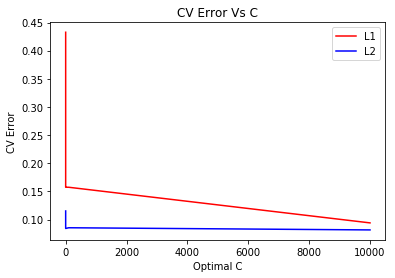

In [34]:
# finding optimal alpha
optimalc_tfidf_grid = find_optimal_C_grid(X_train, Y_train)

In [35]:
# Learning the model with optimal alpha
clf = LogisticRegression(C= 10000, penalty = 'l1')
# fitting the model
clf.fit(X_train,Y_train)

#Predicting the output
pred = clf.predict(X_test)

train_acc_tfidf = clf.score(X_train, Y_train)*100
print("Train accuracy", train_acc_tfidf)

test_acc_tfidf = accuracy_score(Y_test, pred) * 100
print("\nTest accuracy", test_acc_tfidf)

Train accuracy 100.0

Test accuracy 92.30000000000001


             precision    recall  f1-score   support

   negative       0.82      0.65      0.72      4671
   positive       0.94      0.97      0.96     25329

avg / total       0.92      0.92      0.92     30000



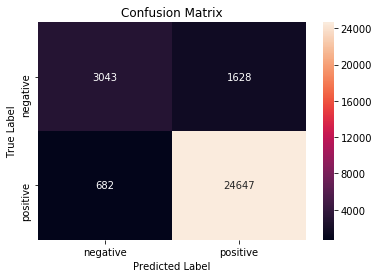

In [36]:
# classification report
print(classification_report(Y_test, pred))

# confusion matrix
class_label = ["negative", "positive"]
cm = confusion_matrix(Y_test, pred)
cm_array = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(cm_array, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### RandomizedSearch CV

{'penalty': 'l2', 'C': 10000}


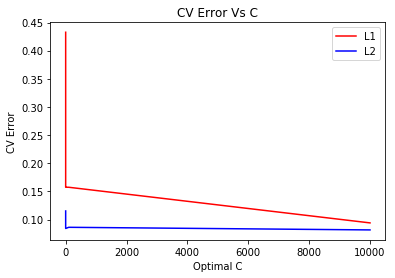

In [37]:
# finding optimal alpha
optimalc_tfidf_random = find_optimal_C_random(X_train, Y_train)

In [38]:
# Learning the model with optimal alpha
clf = LogisticRegression(C= 10000, penalty = 'l2')
# fitting the model
clf.fit(X_train,Y_train)

#Predicting the output
pred = clf.predict(X_test)

train_acc_tfidf = clf.score(X_train, Y_train)*100
print("Train accuracy", train_acc_tfidf)

test_acc_tfidf = accuracy_score(Y_test, pred) * 100
print("\nTest accuracy", test_acc_tfidf)

Train accuracy 100.0

Test accuracy 93.31333333333333


             precision    recall  f1-score   support

   negative       0.85      0.69      0.76      4671
   positive       0.95      0.98      0.96     25329

avg / total       0.93      0.93      0.93     30000



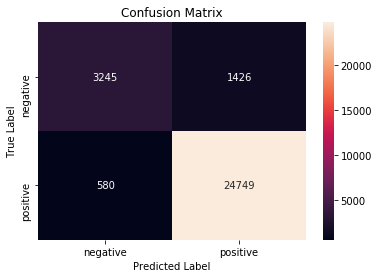

In [39]:
# classification report
print(classification_report(Y_test, pred))

# confusion matrix
class_label = ["negative", "positive"]
cm = confusion_matrix(Y_test, pred)
cm_array = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(cm_array, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

##### Relation between sparisity and lambda

In [46]:
clf = LogisticRegression(C=10000, penalty='l1')
clf.fit(X_train, Y_train)
w = clf.coef_
print(np.count_nonzero(w))

43750


In [47]:
clf = LogisticRegression(C=1000, penalty='l1')
clf.fit(X_train, Y_train)
w = clf.coef_
print(np.count_nonzero(w))

20188


In [48]:
clf = LogisticRegression(C=100, penalty='l1')
clf.fit(X_train, Y_train)
w = clf.coef_
print(np.count_nonzero(w))

15240


In [49]:
clf = LogisticRegression(C=10, penalty='l1')
clf.fit(X_train, Y_train)
w = clf.coef_
print(np.count_nonzero(w))

10741


In [50]:
clf = LogisticRegression(C=0.1, penalty='l1')
clf.fit(X_train, Y_train)
w = clf.coef_
print(np.count_nonzero(w))

103


##### Checking Multicollinearity using Pertubation test

In [52]:
clf = LogisticRegression(C=10000, penalty='l2')
clf.fit(X_train, Y_train)
coef = clf.coef_[0]
print("Weights before adding noise\n")
print(coef[:30])
print(len(coef))

Weights before adding noise

[ 2.72033992e-03  2.72033992e-03  2.31770794e-01  7.06530287e-02
  6.40537844e-03 -1.92906252e-01 -1.92906252e-01  1.80150581e-02
  1.80150581e-02  3.72383406e-02  3.72383406e-02  2.47436258e-02
  4.99370495e-03  2.06572270e-02  1.70214475e-02  1.70214475e-02
 -3.62643725e+00 -7.45538748e-01 -3.01387373e+00  3.60420701e-02
  3.60420701e-02  9.08253720e-03  9.08253720e-03  2.25388794e-01
  1.46134339e-02  1.50233453e-01  1.46134339e-02  5.72190583e-02
  8.29081693e-03  4.88204679e-01]
994209


In [53]:
X_train1 = X_train
noise = np.random.normal(0,0.01) 
X_train1.data = X_train1.data + noise


In [54]:
clf = LogisticRegression(C=0.01, penalty='l2')
clf.fit(X_train1, Y_train)
coef_withNoise = clf.coef_[0]
print("Weights after adding noise\n")
print(coef_withNoise[:30])
print(len(coef))

Weights after adding noise

[ 2.96665171e-05  2.96665171e-05  6.43572610e-04  3.52418281e-04
  2.85393751e-04 -2.35511656e-04 -2.35511656e-04  1.29183151e-04
  1.29183151e-04  1.41441505e-04  1.41441505e-04  4.62516987e-04
  1.22012800e-04  3.58135327e-04  1.14661822e-04  1.14661822e-04
 -3.61282748e-03 -8.59983552e-04 -2.88920094e-03  2.15473836e-04
  2.15473836e-04  5.99554393e-05  5.99554393e-05  5.48635438e-04
  6.33779640e-05  1.49850603e-04  6.33779640e-05  2.19126919e-04
  9.40524010e-05  2.10372108e-04]
994209


In [55]:
Weights_diff = (abs(coef_withNoise-coef)/coef) * 100
print(Weights_diff[:30])
type(Weights_diff)

[ 98.90945551  98.90945551  99.72232368  99.50119862  95.54446699
 -99.87791393 -99.87791393  99.28291571  99.28291571  99.62017237
  99.62017237  98.13076308  97.55666781  98.26629525  99.32636856
  99.32636856 -99.90037529 -99.88464938 -99.90413663  99.40216021
  99.40216021  99.33988226  99.33988226  99.75658265  99.56630341
  99.90025484  99.56630341  99.61703858  98.86558343  99.95690903]


numpy.ndarray

In [56]:
new_list = list(filter(lambda x: x > 30, Weights_diff))
print(len(new_list))

767263


* There is more significant change in weights after adding the noise.
* Almost 767263 features have their weight changees more than 30%. So, we can say that features are multicollinear.
* Hence we cannot use weights as feature importance values.

##### Feature Importance

In [57]:
find_imp_features(tfidf)

Top 25 negative

 [(-0.1283377426996606, 'harmon'), (-0.08832227280220592, 'youll'), (-0.08619639453585025, 'frazier'), (-0.06752412315431477, 'nosey'), (-0.04490843924946127, 'cellulit'), (-0.03881396434537818, 'jax'), (-0.03131463511263602, 'gastrointestin'), (-0.02909322296732971, 'audio'), (-0.0278275760593845, 'bold'), (-0.025759852930245065, 'whoola'), (-0.02569453304075894, 'yumni'), (-0.020628259134493575, 'apon'), (-0.01977882705216838, 'portillo'), (-0.018338933823592144, 'teriaki'), (-0.01811376515236672, 'amora'), (-0.017615125324238156, 'kum'), (-0.01738621633177213, 'yagoozon'), (-0.016748157075094722, 'muriel'), (-0.01647659418933457, 'kimchi'), (-0.01629235958123689, 'substant'), (-0.016056515139603333, 'beetl'), (-0.015677082806967495, 'suprem'), (-0.01549313021470785, 'ambianc'), (-0.014673286227488215, 'juiciest'), (-0.014607712115441108, 'merril')]
-------------------------------------------
Top 25 positive

 [(0.02803768440319321, 'coke'), (0.031398546209809024, 'd

### 3 Word2Vec

In [40]:
X = final_data['CleanedText']
Y = final_data['Score']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
print(X_train.shape,X_test.shape)
#print(X_train)

(70000,) (30000,)


In [41]:
from gensim.models import Word2Vec
i=0

list_of_sent=[]
for sent in X_train:
    list_of_sent.append(sent.split())
    
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
w2v_words = np.array(w2v_words)
w2v_words.shape


(10867,)

In [42]:
from gensim.models import Word2Vec
i=0

list_of_sent_test=[]
for sent in X_test:
    list_of_sent_test.append(sent.split())
w2v_model=Word2Vec(list_of_sent_test,min_count=5,size=50, workers=4)
w2v_model.wv.most_similar('tast')
w2v_words = list(w2v_model.wv.vocab)
w2v_words = np.array(w2v_words)
w2v_words.shape


(7515,)

#### Average W2V

In [43]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors = np.array(sent_vectors)
print(sent_vectors.shape)

(70000, 50)


In [45]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)

(30000, 50)


{'C': 1, 'penalty': 'l1'}


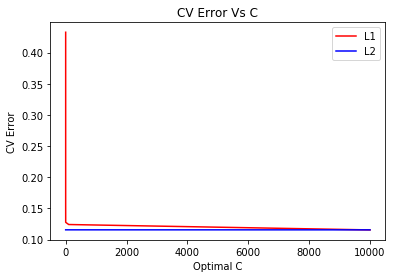

In [46]:
X_train = sent_vectors
X_test = sent_vectors_test

optimalc_avgw2v_grid = find_optimal_C_grid(X_train, Y_train)

In [47]:
# Learning the model with optimal alpha
clf = LogisticRegression(C= 10000, penalty = 'l1')
# fitting the model
clf.fit(X_train,Y_train)

#Predicting the output
pred = clf.predict(X_test)

train_acc_avgw2v = clf.score(X_train, Y_train)*100
print("Train accuracy", train_acc_avgw2v)

test_acc_avgw2v = accuracy_score(Y_test, pred) * 100
print("\nTest accuracy", test_acc_avgw2v)

Train accuracy 88.58714285714285

Test accuracy 88.57000000000001


             precision    recall  f1-score   support

   negative       0.71      0.46      0.55      4671
   positive       0.91      0.96      0.93     25329

avg / total       0.87      0.89      0.88     30000



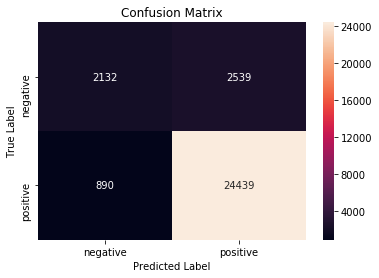

In [48]:
# classification report
print(classification_report(Y_test, pred))

# confusion matrix
class_label = ["negative", "positive"]
cm = confusion_matrix(Y_test, pred)
cm_array = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(cm_array, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

{'penalty': 'l1', 'C': 1}


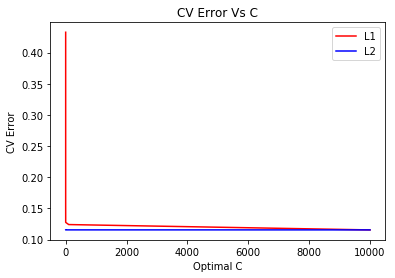

In [49]:
optimalc_avgw2v_random = find_optimal_C_random(X_train, Y_train)

In [50]:
# Learning the model with optimal alpha
clf = LogisticRegression(C= 10000, penalty = 'l1')
# fitting the model
clf.fit(X_train,Y_train)

#Predicting the output
pred = clf.predict(X_test)

train_acc_avgw2v = clf.score(X_train, Y_train)*100
print("Train accuracy", train_acc_avgw2v)

test_acc_tfidf = accuracy_score(Y_test, pred) * 100
print("\nTest accuracy", test_acc_avgw2v)

Train accuracy 88.58428571428571

Test accuracy 88.57000000000001


             precision    recall  f1-score   support

   negative       0.71      0.46      0.55      4671
   positive       0.91      0.96      0.93     25329

avg / total       0.87      0.89      0.88     30000



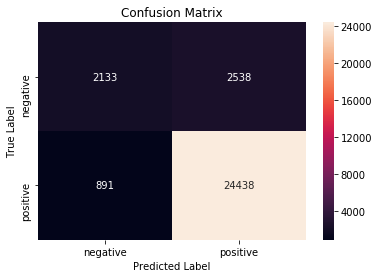

In [51]:
# classification report
print(classification_report(Y_test, pred))

# confusion matrix
class_label = ["negative", "positive"]
cm = confusion_matrix(Y_test, pred)
cm_array = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(cm_array, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

##### Checking Multicollinearity using Pertubation test

In [69]:
clf = LogisticRegression(C=10000, penalty='l1')
clf.fit(X_train, Y_train)
coef = clf.coef_[0]
print("Weights before adding noise\n")
print(coef[:30])
print(len(coef))

Weights before adding noise

[ 1.20174867  0.49509746  1.58787518 -0.63295229 -0.02650552  0.97436779
 -0.58599252  0.20772888 -0.56103141 -0.76384162  0.81163491  0.41408095
  0.53205183  0.63384314  0.56826874  0.84797158 -1.91101618  0.31666114
  0.08960123 -0.42283476  2.08243972 -1.20779083  0.08726236  0.61292142
 -0.01526914  0.24445438 -0.85974016  0.07646699  1.14089688 -0.03015432]
50


In [82]:
from scipy.sparse import csr_matrix
X_train1 = csr_matrix(sent_vectors)
noise = np.random.normal(0,0.01) 
X_train1.data = X_train1.data + noise


In [83]:
clf = LogisticRegression(C=10000, penalty='l1')
clf.fit(X_train1, Y_train)
coef_withNoise = clf.coef_[0]
print("Weights after adding noise\n")
print(coef_withNoise[:30])
print(len(coef))

Weights after adding noise

[ 1.197811    0.49020822  1.59066907 -0.62712734 -0.02113538  0.97442257
 -0.58839517  0.20622795 -0.56734858 -0.77489993  0.82413675  0.3975942
  0.51496704  0.64820981  0.55951338  0.84070235 -1.90722515  0.32385593
  0.06912421 -0.4271447   2.06309525 -1.21581043  0.09726658  0.61073847
 -0.00223766  0.24399583 -0.84688919  0.07435535  1.14407313 -0.02014632]
50


In [84]:
Weights_diff = (abs(coef_withNoise-coef)/coef) * 100
print(Weights_diff[:30])
type(Weights_diff)

[ 3.27661847e-01  9.87531377e-01  1.75951537e-01 -9.20282575e-01
 -2.02604554e+01  5.62154982e-03 -4.10013308e-01  7.22543999e-01
 -1.12599141e+00 -1.44772266e+00  1.54032776e+00  3.98152702e+00
  3.21111486e+00  2.26659697e+00  1.54070837e+00  8.57248601e-01
 -1.98377871e-01  2.27207891e+00  2.28535052e+01 -1.01929667e+00
  9.28933150e-01 -6.63988832e-01  1.14645337e+01  3.56155063e-01
 -8.53452029e+01  1.87581437e-01 -1.49475020e+00  2.76150858e+00
  2.78399230e-01 -3.31892626e+01]


numpy.ndarray

In [86]:
new_list = list(filter(lambda x: x > 20, Weights_diff))
print(len(new_list))

2


### 4 TF-IDF W2V

In [52]:
# Splitting the data into train and test
X = final_data['CleanedText']
Y = final_data['Score']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
print(X_train.shape,X_test.shape)
#print(X_train)

(70000,) (30000,)


In [53]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [54]:
tfidf_feat = tfidf.get_feature_names() # tfidf words/col-names
 
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
tfidf_sent_vectors = np.array(tfidf_sent_vectors)
print(tfidf_sent_vectors.shape)

(70000, 50)


In [55]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

tfidf_feat = tfidf.get_feature_names() 
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)
print(tfidf_sent_vectors_test.shape)

(30000, 50)


In [56]:
X_train = tfidf_sent_vectors
X_test = tfidf_sent_vectors_test


{'C': 1, 'penalty': 'l1'}


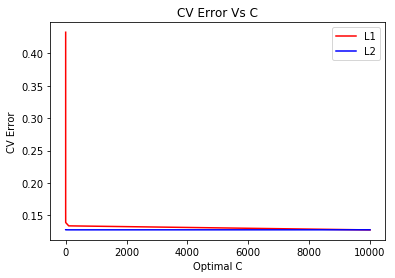

In [57]:
optimalc_tfidfw2v_grid = find_optimal_C_grid(X_train, Y_train)

In [58]:
# Learning the model with optimal alpha
clf = LogisticRegression(C= 100, penalty = 'l1')
# fitting the model
clf.fit(X_train,Y_train)

#Predicting the output
pred = clf.predict(X_test)

train_acc_tfidfw2v = clf.score(X_train, Y_train)*100
print("Train accuracy", train_acc_tfidfw2v)

test_acc_tfidfw2v = accuracy_score(Y_test, pred) * 100
print("\nTest accuracy", test_acc_tfidfw2v)

Train accuracy 87.36857142857143

Test accuracy 87.26


             precision    recall  f1-score   support

   negative       0.67      0.36      0.47      4671
   positive       0.89      0.97      0.93     25329

avg / total       0.86      0.87      0.86     30000



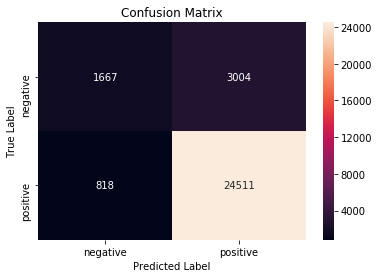

In [59]:
# classification report
print(classification_report(Y_test, pred))

# confusion matrix
class_label = ["negative", "positive"]
cm = confusion_matrix(Y_test, pred)
cm_array = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(cm_array, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

{'penalty': 'l1', 'C': 1}


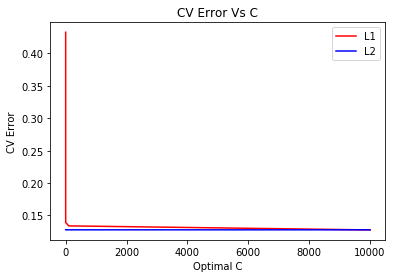

In [60]:
optimalc_tfidfw2v_random = find_optimal_C_random(X_train, Y_train)

In [61]:
# Learning the model with optimal alpha
clf = LogisticRegression(C= 100, penalty = 'l2')
# fitting the model
clf.fit(X_train,Y_train)

#Predicting the output
pred = clf.predict(X_test)

train_acc_tfidfw2v = clf.score(X_train, Y_train)*100
print("Train accuracy", train_acc_tfidfw2v)

test_acc_tfidfw2v = accuracy_score(Y_test, pred) * 100
print("\nTest accuracy", test_acc_tfidfw2v)

Train accuracy 87.36714285714285

Test accuracy 87.26


             precision    recall  f1-score   support

   negative       0.67      0.36      0.47      4671
   positive       0.89      0.97      0.93     25329

avg / total       0.86      0.87      0.86     30000



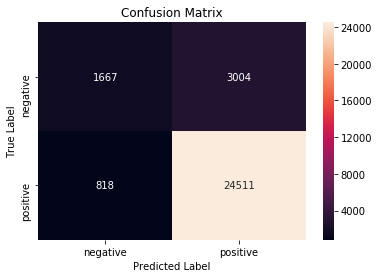

In [62]:
# classification report
print(classification_report(Y_test, pred))

# confusion matrix
class_label = ["negative", "positive"]
cm = confusion_matrix(Y_test, pred)
cm_array = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(cm_array, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

##### Checking Multicollinearity using Pertubation test

In [99]:
clf = LogisticRegression(C=0.0001, penalty='l2')
clf.fit(X_train, Y_train)
coef = clf.coef_[0]
print("Weights before adding noise\n")
print(coef[:30])
print(len(coef))

Weights before adding noise

[ 0.02250589  0.07957099  0.07020856  0.00360716 -0.03466307  0.11529928
 -0.03637838 -0.01761293 -0.12210004 -0.00900095 -0.03294464  0.0759766
  0.12238841  0.02798842  0.07714511  0.12813774 -0.08767449  0.04086689
  0.18317162  0.07532723  0.31447913 -0.04720879 -0.11207769  0.1964609
 -0.06680154  0.04797506 -0.15902309  0.04837199  0.1177901  -0.16791774]
50


In [101]:
X_train1 = csr_matrix(tfidf_sent_vectors)
noise = np.random.normal(0,0.01) 
X_train1.data = X_train1.data + noise


In [102]:
clf = LogisticRegression(C=0.0001, penalty='l2')
clf.fit(X_train1, Y_train)
coef_withNoise = clf.coef_[0]
print("Weights after adding noise\n")
print(coef_withNoise[:30])
print(len(coef))

Weights after adding noise

[ 0.02577662  0.08327542  0.0772661   0.00725346 -0.02767199  0.12132734
 -0.03159133 -0.01216361 -0.11596847 -0.0042297  -0.02465881  0.07960101
  0.12704805  0.0352626   0.08098224  0.12941838 -0.08140989  0.04744444
  0.18429721  0.07777161  0.31486017 -0.04154217 -0.10451842  0.19849751
 -0.06091825  0.05148696 -0.15137029  0.05197678  0.12223691 -0.15826278]
50


In [103]:
Weights_diff = (abs(coef_withNoise-coef)/coef) * 100
print(Weights_diff[:30])
type(Weights_diff)

[ 14.53273156   4.65550461  10.05226069 101.08533411 -20.16866229
   5.22818649 -13.15903513 -30.93929428  -5.02175352 -53.00828977
 -25.15076229   4.77042951   3.80725629  25.98996602   4.97391261
   0.99942449  -7.14528657  16.09506676   0.61450051   3.24501267
   0.12116647 -12.00331324  -6.74466531   1.03664739  -8.8071193
   7.32025549  -4.8123837    7.45222453   3.77519957  -5.74981554]


numpy.ndarray

In [106]:
new_list = list(filter(lambda x: x > 20, Weights_diff))
print(len(new_list))

4


In [63]:
x = PrettyTable()

x.field_names = ["Vectorisation", "CV","Optimal C", "Penalty", "F1-score"]

x.add_row(["BOW","GridSearchCV","0.01","L1","0.90"])
x.add_row(["BOW","RandomizedSearchCV","0.01","L1","0.90"])

x.add_row(["TF-IDF","GridSearchCV","10000","L2","0.92"])
x.add_row(["TF-IDF","RandomizedSearchCV","10000","L2","0.93"])

x.add_row(["Average W2V","GridSearchCV","1","L1","0.88"])
x.add_row(["Average W2V","RandomizedSearchCV","1","L1","0.88"])

x.add_row(["TF-IDF W2V","GridSearchCV","1","L1","0.86"])
x.add_row(["TF-IDF W2V","RandomizedSearchCV","1","L1","0.86"])


print(x)

+---------------+--------------------+-----------+---------+----------+
| Vectorisation |         CV         | Optimal C | Penalty | F1-score |
+---------------+--------------------+-----------+---------+----------+
|      BOW      |    GridSearchCV    |    0.01   |    L1   |   0.90   |
|      BOW      | RandomizedSearchCV |    0.01   |    L1   |   0.90   |
|     TF-IDF    |    GridSearchCV    |   10000   |    L2   |   0.92   |
|     TF-IDF    | RandomizedSearchCV |   10000   |    L2   |   0.93   |
|  Average W2V  |    GridSearchCV    |     1     |    L1   |   0.88   |
|  Average W2V  | RandomizedSearchCV |     1     |    L1   |   0.88   |
|   TF-IDF W2V  |    GridSearchCV    |     1     |    L1   |   0.86   |
|   TF-IDF W2V  | RandomizedSearchCV |     1     |    L1   |   0.86   |
+---------------+--------------------+-----------+---------+----------+


### 5 Conclusion

* BOW and TF-IDF performed well with F1-score of 0.9 and 0.92 respectively.
* As lambda increases/C decreases the sparsity increases.
* Features are multicollinear, so we cannot use weights as feature importance values.
* Logistic Regression is faster in its traning time than other algorithms like KNN and it performed well on this dataset.
* So logistic Regression can be used in low-latency applications.